# An AI application

In this project, I train an image classifier to recognize different species of flowers. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below (to save space, I didn'd include the dataset in this repository): 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from collections import OrderedDict
from PIL import Image
import numpy as np



## Load the data

The dataset is split into three parts, training, validation, and testing. For the training, I apply data augmentation transformations such as random scaling, cropping, and flipping. It is noted that for all three sets, each input data is resized to 224x224 pixels as required by the pre-trained networks. I also normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, which are calculated from the ImageNet images as the pre-trained network is trained on it. 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.RandomRotation(38),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
dev_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform = train_transforms) 
dev_data = datasets.ImageFolder(valid_dir, transform = dev_transforms)
test_data = datasets.ImageFolder(test_dir, transform = test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloaders = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
devloaders = torch.utils.data.DataLoader(dev_data, batch_size = 32)
testloaders = torch.utils.data.DataLoader(test_data, batch_size = 32)
testloaders_inf = torch.utils.data.DataLoader(test_data, batch_size = 1)

### Label mapping

Here I load in a mapping from category label to category name. You can find this in the file `cat_to_name.json` in this repository, which is a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

I use VGG16 to get the image features. Build and train a new feed-forward classifier using those features.

In [4]:
# TODO: Build and train your network

model = models.vgg16(pretrained = True)
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4096)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(4096, 102)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

model
    


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:17<00:00, 31861875.78it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    batch_count = 0
    for images, labels in testloader:
        batch_count += 1
        images, labels = images.to('cuda'), labels.to('cuda')
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim = 1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        print('equality is', equality, 'accuracy is', accuracy)
    accuracy = accuracy/batch_count        
    return test_loss, accuracy

In [9]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)
epochs = 1
print_every = 50
steps = 0

model.to('cuda')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [27]:

for e in range(epochs):
    running_loss = 0
    for inputs, labels in iter(trainloaders):
        steps += 1
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            model.eval()
            test_loss, accuracy = validation(model, devloaders, criterion)
            print("Epoch: {}/{}... ".format(steps, e+1),
                  "Loss: {:.4f}".format(running_loss/print_every), 
                 "test_loss: {:.4f}".format(test_loss),
                  "accuracy:{:.4f}".format(accuracy))
            running_loss = 0
            model.train()

equality is tensor([ 0,  1,  1,  1,  0,  1,  0,  1,  0,  0,  1,  1,  1,  1,
         1,  0,  0,  0,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,
         0,  1,  0,  0], dtype=torch.uint8, device='cuda:0') accuracy is tensor(0.6250)
equality is tensor([ 0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  1,  0,  1,  1,
         0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  1], dtype=torch.uint8, device='cuda:0') accuracy is tensor(1.0312)
equality is tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,
         1,  0,  1,  0,  1,  1,  1,  1,  0,  0,  1,  0,  1,  1,
         1,  1,  1,  1], dtype=torch.uint8, device='cuda:0') accuracy is tensor(1.8438)
equality is tensor([ 0,  0,  0,  1,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,
         1,  1,  0,  1,  1,  1,  0,  1,  1,  1,  1,  0,  1,  1,
         1,  1,  1,  1], dtype=torch.uint8, device='cuda:0') accuracy is tensor(2.5000)
equality is tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  0,  1,
         0, 

## Testing network



In [14]:
# Do validation on the test set

test_loss, accuracy = validation(model, testloaders, criterion)
print("test_loss: {:.4f}".format(test_loss),
      "accuracy:{:.4f}".format(accuracy))

equality is tensor([ 1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  0,  0,  0,  0,  0,  1,  1,  1,  0,  1,  1,  0,  0,
         0,  0,  0,  1], dtype=torch.uint8, device='cuda:0') accuracy is tensor(0.6250)
equality is tensor([ 0,  0,  0,  1,  1,  0,  1,  0,  1,  1,  1,  1,  0,  1,
         0,  1,  1,  0,  1,  1,  1,  0,  1,  0,  0,  0,  1,  0,
         1,  1,  1,  1], dtype=torch.uint8, device='cuda:0') accuracy is tensor(1.2188)
equality is tensor([ 1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  0,  0,
         1,  0,  0,  1,  1,  0,  1,  1,  1,  0,  1,  1,  0,  1,
         1,  1,  0,  1], dtype=torch.uint8, device='cuda:0') accuracy is tensor(1.9375)
equality is tensor([ 1,  1,  0,  1,  1,  1,  1,  0,  1,  1,  1,  0,  1,  1,
         0,  1,  0,  1,  0,  1,  1,  1,  1,  0,  1,  1,  0,  0,
         1,  0,  1,  1], dtype=torch.uint8, device='cuda:0') accuracy is tensor(2.6250)
equality is tensor([ 0,  1,  1,  0,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1, 

## Save the checkpoint


In [76]:
# Save the checkpoint 
# torch.save(model.state_dict(), 'checkpoint.pth')

model.class_to_idx = train_data.class_to_idx


checkpoint = {'classifier':nn.Sequential(OrderedDict([
                ('fc1', nn.Linear(25088, 4096)),
                ('relu', nn.ReLU()),
                ('fc2', nn.Linear(4096, 102)),
                ('output', nn.LogSoftmax(dim=1))
            ])),
              'state_dict': model.state_dict(),
              'class_to_index':model.class_to_idx
             }
torch.save(checkpoint, 'checkpoint1.pth')






## Loading the checkpoint

If you have a saved checkpoint, you can use it to come back to this project and keep working on it without having to retrain the network.

In [6]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
# state_dict = torch.load('checkpoint.pth')
# print(state_dict.keys())
# model.load_state_dict(state_dict)
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.vgg16(pretrained = True)
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])   
    return model
model = load_checkpoint('checkpoint1.pth')
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

## Image Preprocessing

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. The size is cropped out the center 224x224 portion of the image.

In [7]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    im = Image.open(image)
    max_min_ratio = max(im.size)/min(im.size)
    size = 256*max_min_ratio, 256*max_min_ratio
    im.thumbnail(size)
    center_position = int(im.size[0]/2-112), int(im.size[1]/2-112), int(im.size[0]/2+112), int(im.size[1]/2+112)
    im = im.crop(center_position)
    np_image = np.array(im)
    np_image = np_image/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image-mean)/std
    np_image = np_image.transpose((2,0,1))
    return np_image
    
    # TODO: Process a PIL image for use in a PyTorch model

Follow up the process_image function, running the output through this reverse function should return the original image (except for the cropped out portions).

In [8]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


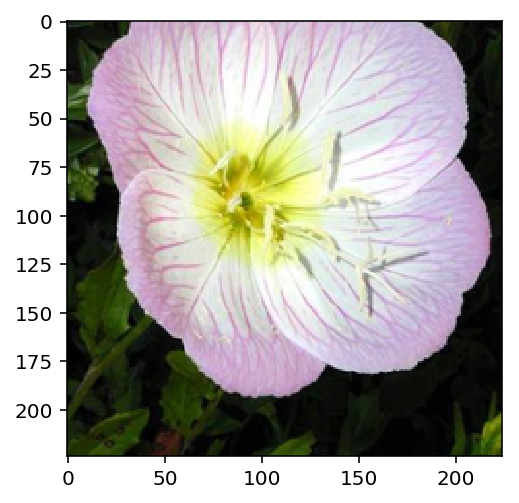

In [9]:
# test_image = Image.open('./flowers/test/1/image_06743.jpg')
processed_image = process_image('./flowers/test/1/image_06743.jpg')
out_image = imshow(processed_image)

## Class Prediction

This function can predict the top 5 or so (usually called top-$K$) most probable classes. You can calculate the class probabilities and then find the $K$ largest values.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [15]:
# checkpoint = torch.load('checkpoint1.pth')
# # print(checkpoint['class_to_index'])
# index_to_class = {v: k for k, v in checkpoint['class_to_index'].items()}
# print(index_to_class)
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    checkpoint = torch.load('checkpoint1.pth')
    index_to_class = {v: k for k, v in checkpoint['class_to_index'].items()}
    model.to('cuda')
    model.eval()
    im = process_image(image_path)
    im_tensor = torch.from_numpy(im).to('cuda').unsqueeze_(0)
    output = model.forward(im_tensor.float())
    ps = torch.exp(output)
    probs = list(ps.topk(topk)[0].cpu().detach().numpy()[0])
    indices = ps.topk(topk)[1].cpu().detach().numpy()[0]
    classes = []
    names= []
    with open('cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)
        for i in range(topk):
            idx = indices[i]
            class_ = index_to_class[idx]
            classes.append(class_)
            names.append(cat_to_name[class_])
    return probs, classes, names


test = predict('./flowers/test/1/image_06743.jpg', model)
print(test)



([0.6495288, 0.2056578, 0.095286898, 0.027514866, 0.00727743], ['1', '83', '86', '89', '18'], ['pink primrose', 'hibiscus', 'tree mallow', 'watercress', 'peruvian lily'])


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense.

[0.6495288, 0.2056578, 0.095286898, 0.027514866, 0.00727743] ['pink primrose', 'hibiscus', 'tree mallow', 'watercress', 'peruvian lily']
pink primrose


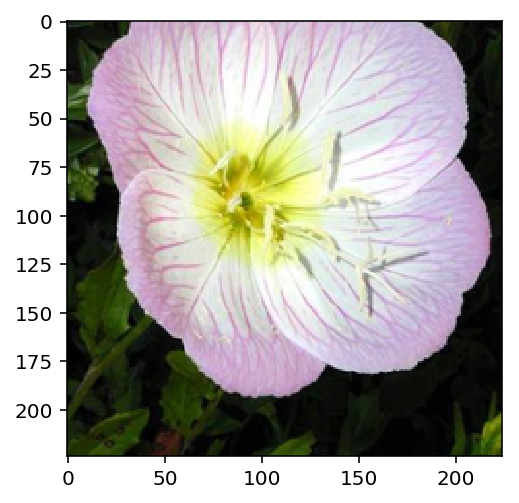

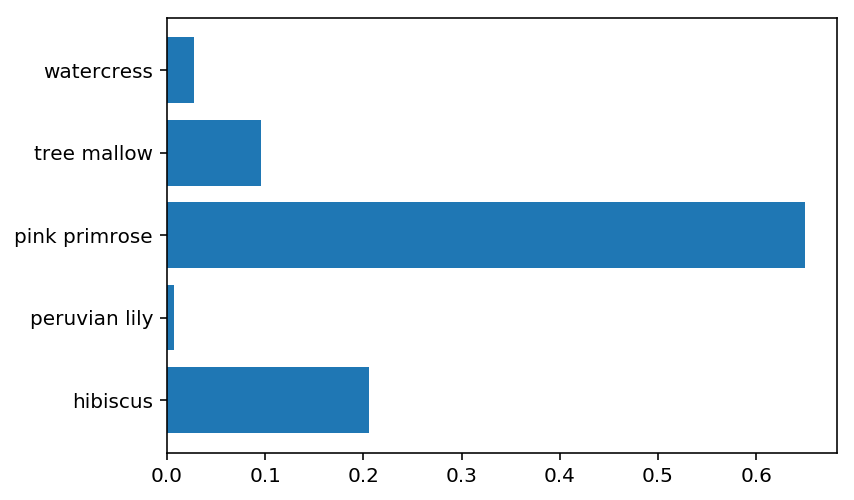

In [17]:
# Display an image along with the top 5 classes
file_path = './flowers/test/1/image_06743.jpg'
probs, classes, names = predict(file_path, model, topk=5)

print(names[0])

processed_image = process_image(file_path)
out_image = imshow(processed_image)
plt.figure()
plt.barh(names, probs)
plt.show()